[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalieching/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natalieching/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Average Sentiment for USA: 0.06935544032855588
Average Sentiment for China: 0.04635066181366935


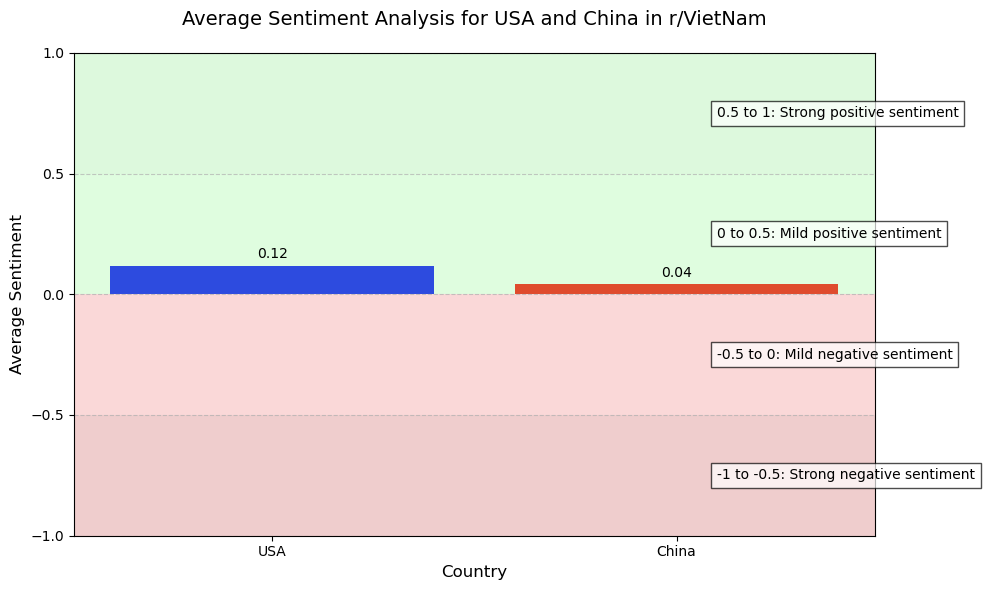

Total number of comments: 10093


In [1]:
import praw
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from langdetect import detect, LangDetectException
from textblob import TextBlob
from textblob.exceptions import NotTranslated

# Download necessary NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize PRAW
reddit = praw.Reddit(
    client_id="Ci2PFvmlrfRvEHMo3_idyQ",
    client_secret="DmIml05C3tyQc3NOmhiS1AstApesdQ",
    user_agent="Comment Extraction (by u/Positive_Lie3685)",
)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define keywords for sentiment analysis
usa_keywords = ['usa', 'america', 'americas', 'mỹ', 'hoa kỳ', 'united states']
china_keywords = ['china', 'chinese', 'trung quốc', 'tàu']

# Function to clean text
def clean_text(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove non-letters
    text = text.lower()  # Lowercase text
    # Tokenization and removing stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Function to analyze sentiment
def analyze_sentiment(text):
    if not text.strip():  # Check if text is empty or contains only whitespace
        return 0  # Neutral sentiment for empty text

    try:
        # Detect the language of the text
        language = detect(text)
        
        # Use English sentiment analysis
        if language == 'en':
            blob = TextBlob(text)
            return blob.sentiment.polarity
        
        # Placeholder for Vietnamese sentiment analysis
        # You would replace this with actual Vietnamese sentiment analysis if available
        return 0  # Neutral sentiment if no analysis is available
        
    except (LangDetectException, NotTranslated) as e:
        print(f"Error analyzing sentiment: {e}")
        return 0  # Neutral sentiment if an error occurs

# Function to check if text contains any of the keywords
def contains_keyword(text, keywords):
    text = text.lower()  # Convert text to lowercase for matching
    return any(keyword in text for keyword in keywords)

# Creating subreddit instance
subreddit_name = "VietNam"
subreddit = reddit.subreddit(subreddit_name)

# Initialize lists to store post data, comments, comment upvotes, and sentiment scores
titles = []
scores = []
ids = []
all_comments = []
comment_upvotes = []
comment_sentiments = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=500):
    titles.append(submission.title)
    scores.append(submission.score)
    ids.append(submission.id)
    
    # Fetch comments from the current post
    submission.comments.replace_more(limit=None)  # This line ensures you get all comments by removing the "MoreComments" instances
    comments = []
    upvotes = []
    sentiments = []
    for comment in submission.comments.list():
        cleaned_comment = clean_text(comment.body)
        comments.append(cleaned_comment)
        upvotes.append(comment.score)  # Track upvotes for each comment
        sentiments.append(analyze_sentiment(cleaned_comment))  # Analyze sentiment
    all_comments.append(comments)
    comment_upvotes.append(upvotes)
    comment_sentiments.append(sentiments)

# Create DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Id': ids,
    'Upvotes': scores,
    'Comments': all_comments,
    'Comment_Upvotes': comment_upvotes,
    'Comment_Sentiments': comment_sentiments
})

# Save DataFrame to CSV
df.to_csv('reddit_vietnam_sentiment_data.csv', index=False)

# Perform sentiment analysis for specific keywords
def calculate_average_sentiment(df, keywords):
    sentiments = []
    total_upvotes = 0
    weighted_sentiments = 0
    
    for comments, upvotes in zip(df['Comments'], df['Comment_Upvotes']):
        for comment, upvote in zip(comments, upvotes):
            if contains_keyword(comment, keywords):
                sentiment = analyze_sentiment(comment)
                sentiments.append(sentiment * upvote)  # Multiply sentiment by upvotes for importance
                weighted_sentiments += sentiment * upvote
                total_upvotes += upvote
    
    if total_upvotes > 0:
        weighted_average_sentiment = weighted_sentiments / total_upvotes
        return weighted_average_sentiment
    return 0

# Calculate average sentiment for USA and China
usa_average_sentiment = calculate_average_sentiment(df, usa_keywords)
china_average_sentiment = calculate_average_sentiment(df, china_keywords)

print(f"Average Sentiment for USA: {usa_average_sentiment}")
print(f"Average Sentiment for China: {china_average_sentiment}")

import matplotlib.pyplot as plt
import numpy as np

# Data
usa_average_sentiment = 0.1189396737919763  # Example value, replace with actual data
china_average_sentiment = 0.04110618062366072  # Example value, replace with actual data
categories = ['USA', 'China']
average_sentiments = [usa_average_sentiment, china_average_sentiment]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot
bars = ax.bar(categories, average_sentiments, color=['blue', 'red'])

# Set labels and title
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Average Sentiment', fontsize=12)
ax.set_title('Average Sentiment Analysis for USA and China in r/VietNam', fontsize=14, pad=20)

# Set y-axis limits and ticks
ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.1, 0.5))

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add background shading for sentiment ranges
ax.axhspan(0.5, 1, facecolor='lightgreen', alpha=0.3)
ax.axhspan(0, 0.5, facecolor='palegreen', alpha=0.3)
ax.axhspan(-0.5, 0, facecolor='lightcoral', alpha=0.3)
ax.axhspan(-1, -0.5, facecolor='indianred', alpha=0.3)

# Add sentiment labels
ax.text(1.1, 0.75, '0.5 to 1: Strong positive sentiment', fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7))
ax.text(1.1, 0.25, '0 to 0.5: Mild positive sentiment', fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7))
ax.text(1.1, -0.25, '-0.5 to 0: Mild negative sentiment', fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7))
ax.text(1.1, -0.75, '-1 to -0.5: Strong negative sentiment', fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7))

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

# Calculate the number of comments for each post
df['Num_Comments'] = df['Comments'].apply(len)

# Calculate the total number of comments
total_comments = df['Num_Comments'].sum()

print(f"Total number of comments: {total_comments}")


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect, LangDetectException
from textblob import TextBlob
import praw
from prettytable import PrettyTable

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize PRAW
reddit = praw.Reddit(
    client_id="Ci2PFvmlrfRvEHMo3_idyQ",
    client_secret="DmIml05C3tyQc3NOmhiS1AstApesdQ",
    user_agent="Comment Extraction (by u/Positive_Lie3685)",
)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define keywords for sentiment analysis
usa_keywords = ['usa', 'america', 'americas', 'mỹ', 'hoa kỳ', 'united states']
china_keywords = ['china', 'chinese', 'trung quốc', 'tàu']
all_keywords = usa_keywords + china_keywords

# Function to clean text
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove non-letters
    text = text.lower()  # Lowercase text
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Function to analyze sentiment
def analyze_sentiment(text):
    if not text.strip():  # Check if text is empty or contains only whitespace
        return 0  # Neutral sentiment for empty text

    try:
        language = detect(text)
        
        if language == 'en':
            blob = TextBlob(text)
            return blob.sentiment.polarity
        
        return 0  # Neutral sentiment if no analysis is available
        
    except LangDetectException:
        return 0  # Neutral sentiment if an error occurs

# Function to check if text contains any of the keywords
def contains_keyword(text, keywords):
    text = text.lower()  # Convert text to lowercase for matching
    return any(keyword in text for keyword in keywords)

# Creating subreddit instance
subreddit_name = "VietNam"
subreddit = reddit.subreddit(subreddit_name)

# Initialize lists to store post data, comments, comment upvotes, and sentiment scores
titles = []
scores = []
ids = []
all_comments = []
comment_upvotes = []
comment_sentiments = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=100):  # Increased limit to ensure we get enough filtered posts
    # Check if the title contains any of the keywords
    if contains_keyword(submission.title, all_keywords):
        titles.append(submission.title)
        scores.append(submission.score)
        ids.append(submission.id)
        
        # Fetch comments from the current post
        submission.comments.replace_more(limit=None)  # This line ensures you get all comments by removing the "MoreComments" instances
        comments = []
        upvotes = []
        sentiments = []
        for comment in submission.comments.list():
            cleaned_comment = clean_text(comment.body)
            if contains_keyword(cleaned_comment, all_keywords):
                comments.append(cleaned_comment)
                upvotes.append(comment.score)  # Track upvotes for each comment
                sentiments.append(analyze_sentiment(cleaned_comment))  # Analyze sentiment
        all_comments.append(comments)
        comment_upvotes.append(upvotes)
        comment_sentiments.append(sentiments)

# Create DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Id': ids,
    'Upvotes': scores,
    'Comments': all_comments,
    'Comment_Upvotes': comment_upvotes,
    'Comment_Sentiments': comment_sentiments
})

# Save DataFrame to CSV
df.to_csv('reddit_vietnam_sentiment_data_filtered.csv', index=False)

# Limit the number of comments and sentiments to show for brevity
max_comments = 2

# Function to format comments, upvotes, and sentiments
def format_comments(comments, upvotes, sentiments, max_comments):
    formatted_comments = []
    for i in range(len(comments)):
        formatted_comments.append(
            f"Comment: {comments[i]}\nUpvotes: {upvotes[i]}\nSentiment: {sentiments[i]:.2f}"
        )
        if i >= max_comments - 1:
            break
    return '\n\n'.join(formatted_comments)

# Create PrettyTable
table = PrettyTable()
table.field_names = ["Post Title", "Post ID", "Post Upvotes", "Top Comments (Limited)"]

# Display at most 5 posts
max_posts = 5

for i in range(min(len(df), max_posts)):
    comments = format_comments(df['Comments'][i], df['Comment_Upvotes'][i], df['Comment_Sentiments'][i], max_comments)
    table.add_row([df['Title'][i], df['Id'][i], df['Upvotes'][i], comments])

# Adjust column widths for better readability
table.max_width["Post Title"] = 20
table.max_width["Top Comments (Limited)"] = 50

# Print the PrettyTable
print(table)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalieching/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natalieching/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+----------------------+---------+--------------+----------------------------------------------------+
|      Post Title      | Post ID | Post Upvotes |               Top Comments (Limited)               |
+----------------------+---------+--------------+----------------------------------------------------+
|   Study abroad for   | 1e6ii2g |      7       | Comment: school america cost alot rich afford want |
|   master's in USA    |         |              |   experience go else never able pay back vietnam   |
|                      |         |              |     salary certification america also flexible     |
|                      |         |              |  something vietnam decided move european country   |
|                      |         |              | australia later life may take certification u who  |
|                      |         |              |          know certify vietnam university           |
|                      |         |              |                     Upv

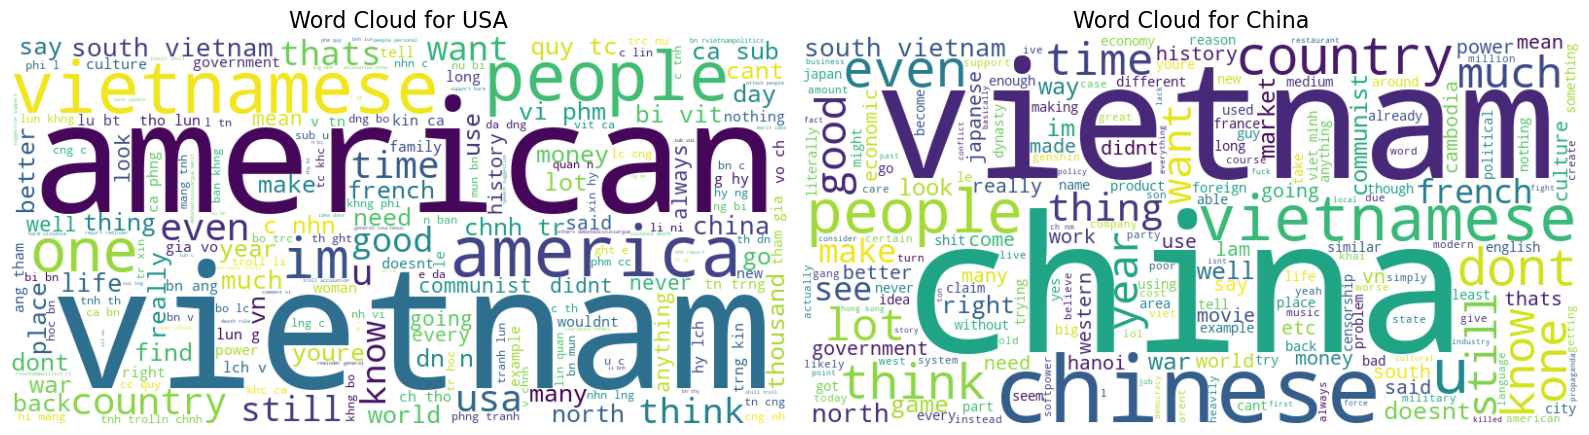

In [3]:
import praw
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define keywords for sentiment analysis
usa_keywords = ['usa', 'america', 'americas', 'mỹ', 'hoa kỳ', 'united states']
china_keywords = ['china', 'chinese', 'trung quốc', 'tàu']

# Function to clean text
def clean_text(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove non-letters
    text = text.lower()  # Lowercase text
    # Tokenization and removing stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Function to check if text contains any of the keywords
def contains_keyword(text, keywords):
    text = text.lower()  # Convert text to lowercase for matching
    return any(keyword in text for keyword in keywords)

# Load the DataFrame
df = pd.read_csv('reddit_vietnam_sentiment_data.csv')

# Extract and clean comments containing USA and China keywords
usa_comments = []
china_comments = []

for comments in df['Comments']:
    comments = eval(comments)  # Convert string representation of list back to list
    for comment in comments:
        cleaned_comment = clean_text(comment)
        if contains_keyword(cleaned_comment, usa_keywords):
            usa_comments.append(cleaned_comment)
        if contains_keyword(cleaned_comment, china_keywords):
            china_comments.append(cleaned_comment)

# Generate word clouds
usa_text = ' '.join(usa_comments)
china_text = ' '.join(china_comments)

usa_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(usa_text)
china_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(china_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(usa_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for USA', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(china_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for China', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

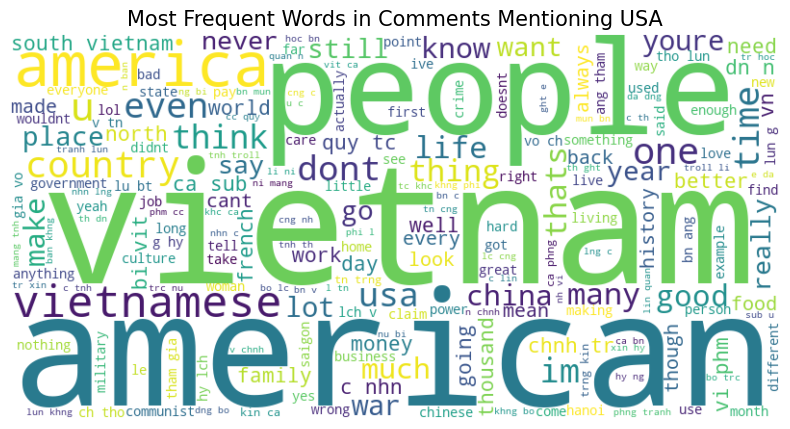

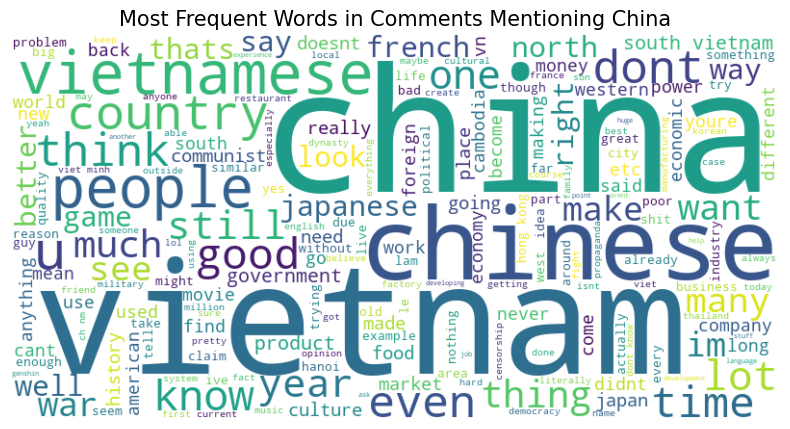

In [3]:
from collections import Counter
from wordcloud import WordCloud

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

# Function to get most frequent words
def get_most_frequent_words(df, keywords):
    text = ''
    
    for comments in df['Comments']:
        for comment in comments:
            if contains_keyword(comment, keywords):
                text += ' ' + comment
    
    return text

# Get most frequent words for each group
usa_text = get_most_frequent_words(df, usa_keywords)
china_text = get_most_frequent_words(df, china_keywords)

# Generate word clouds
generate_word_cloud(usa_text, 'Most Frequent Words in Comments Mentioning USA')
generate_word_cloud(china_text, 'Most Frequent Words in Comments Mentioning China')


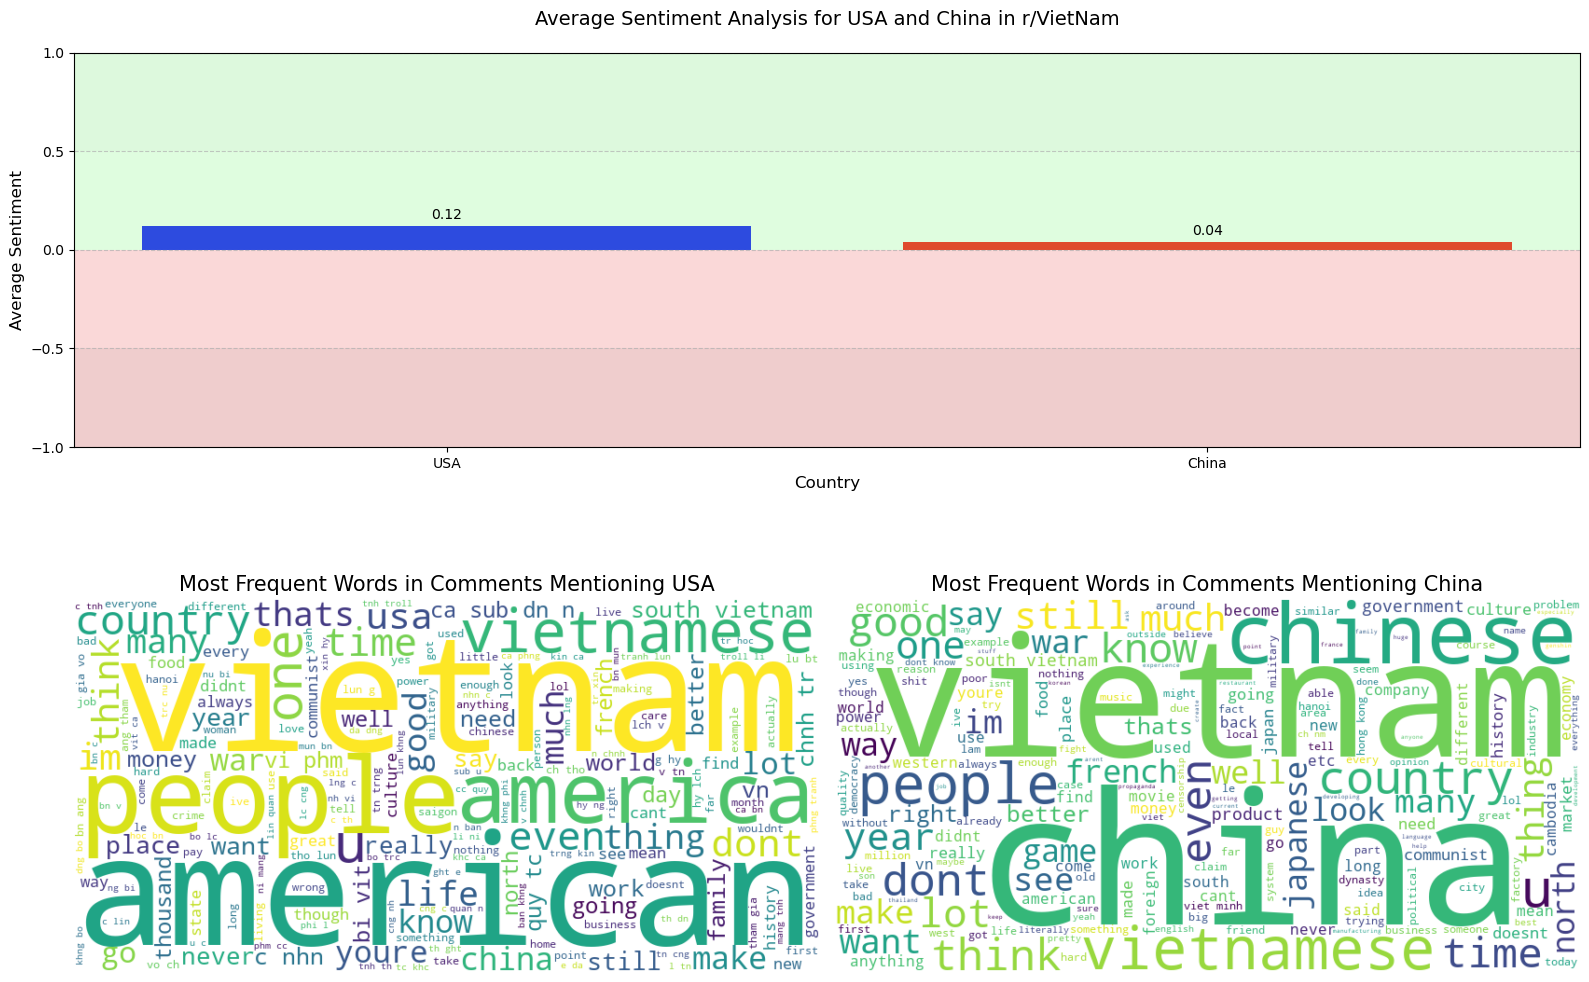

In [4]:
import matplotlib.gridspec as gridspec

# Create figure and gridspec
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])

# Bar plot for sentiment analysis
ax1 = fig.add_subplot(gs[0, :])
bars = ax1.bar(categories, average_sentiments, color=['blue', 'red'])
ax1.set_xlabel('Country', fontsize=12)
ax1.set_ylabel('Average Sentiment', fontsize=12)
ax1.set_title('Average Sentiment Analysis for USA and China in r/VietNam', fontsize=14, pad=20)
ax1.set_ylim(-1, 1)
ax1.set_yticks(np.arange(-1, 1.1, 0.5))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.axhspan(0.5, 1, facecolor='lightgreen', alpha=0.3)
ax1.axhspan(0, 0.5, facecolor='palegreen', alpha=0.3)
ax1.axhspan(-0.5, 0, facecolor='lightcoral', alpha=0.3)
ax1.axhspan(-1, -0.5, facecolor='indianred', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Word cloud for USA
ax2 = fig.add_subplot(gs[1, 0])
wordcloud_usa = WordCloud(width=800, height=400, background_color='white').generate(usa_text)
ax2.imshow(wordcloud_usa, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most Frequent Words in Comments Mentioning USA', fontsize=15)

# Word cloud for China
ax3 = fig.add_subplot(gs[1, 1])
wordcloud_china = WordCloud(width=800, height=400, background_color='white').generate(china_text)
ax3.imshow(wordcloud_china, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Most Frequent Words in Comments Mentioning China', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
from collections import Counter
import pandas as pd
from IPython.display import display, HTML

# Function to clean text
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove non-letters
    text = text.lower()  # Lowercase text
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Function to check if text contains any of the keywords
def contains_keyword(text, keywords):
    text = text.lower()  # Convert text to lowercase for matching
    return any(keyword in text for keyword in keywords)

# Function to get most frequent words and their counts
def get_word_frequencies(text):
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(20)  # Get the 20 most common words

# Creating subreddit instance
subreddit_name = "VietNam"
subreddit = reddit.subreddit(subreddit_name)

# Initialize lists to store post data, comments, comment upvotes, and sentiment scores
titles = []
scores = []
ids = []
all_comments = []
comment_upvotes = []
comment_sentiments = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=500):
    titles.append(submission.title)
    scores.append(submission.score)
    ids.append(submission.id)
    
    # Fetch comments from the current post
    submission.comments.replace_more(limit=None)
    comments = []
    upvotes = []
    for comment in submission.comments.list():
        cleaned_comment = clean_text(comment.body)
        comments.append(cleaned_comment)
        upvotes.append(comment.score)
    all_comments.append(comments)
    comment_upvotes.append(upvotes)

# Create DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Id': ids,
    'Upvotes': scores,
    'Comments': all_comments,
    'Comment_Upvotes': comment_upvotes
})

# Get most frequent words for each group
usa_text = ' '.join([' '.join(comments) for comments in df['Comments'] if any(contains_keyword(comment, usa_keywords) for comment in comments)])
china_text = ' '.join([' '.join(comments) for comments in df['Comments'] if any(contains_keyword(comment, china_keywords) for comment in comments)])

# Get word frequencies
usa_word_counts = get_word_frequencies(usa_text)
china_word_counts = get_word_frequencies(china_text)

# Create DataFrames
usa_df = pd.DataFrame(usa_word_counts, columns=['Word', 'Frequency'])
china_df = pd.DataFrame(china_word_counts, columns=['Word', 'Frequency'])

# Display the DataFrames
print("Most Frequent Words in Comments Mentioning USA")
display(HTML(usa_df.to_html(index=False)))

print("\nMost Frequent Words in Comments Mentioning China")
display(HTML(china_df.to_html(index=False)))

Most Frequent Words in Comments Mentioning USA


Word,Frequency
vietnam,1485
people,1260
like,1224
dont,1001
vietnamese,896
one,747
get,700
u,691
country,672
time,653



Most Frequent Words in Comments Mentioning China


Word,Frequency
vietnam,1219
people,1031
like,965
dont,773
vietnamese,712
one,612
u,594
country,565
get,519
think,490


In [8]:
from collections import Counter
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect, LangDetectException
from textblob import TextBlob
from textblob.exceptions import NotTranslated
from IPython.display import display, HTML
import re

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove non-letters
    text = text.lower()  # Lowercase text
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return tokens

# Function to analyze sentiment
def analyze_sentiment(text):
    if not text.strip():  # Check if text is empty or contains only whitespace
        return 0  # Neutral sentiment for empty text

    try:
        # Detect the language of the text
        language = detect(text)
        
        # Use English sentiment analysis
        if language == 'en':
            blob = TextBlob(text)
            return blob.sentiment.polarity
        
        # Placeholder for Vietnamese sentiment analysis
        # You would replace this with actual Vietnamese sentiment analysis if available
        return 0  # Neutral sentiment if no analysis is available
        
    except (LangDetectException, NotTranslated) as e:
        return 0  # Neutral sentiment if an error occurs

# Function to check if text contains any of the keywords
def contains_keyword(text, keywords):
    text = text.lower()  # Convert text to lowercase for matching
    return any(keyword in text for keyword in keywords)

# Function to get most frequent words with highest sentiment influence
def get_influential_words(df, keywords):
    influential_words = Counter()
    
    for comments, sentiments in zip(df['Comments'], df['Comment_Sentiments']):
        for comment, sentiment in zip(comments, sentiments):
            if contains_keyword(comment, keywords):
                words = clean_text(comment)
                for word in words:
                    influential_words[word] += abs(sentiment)
    
    return influential_words.most_common(20)  # Get the 20 most common words

# Creating subreddit instance
subreddit_name = "VietNam"
subreddit = reddit.subreddit(subreddit_name)

# Initialize lists to store post data, comments, comment upvotes, and sentiment scores
titles = []
scores = []
ids = []
all_comments = []
comment_upvotes = []
comment_sentiments = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=500):
    titles.append(submission.title)
    scores.append(submission.score)
    ids.append(submission.id)
    
    # Fetch comments from the current post
    submission.comments.replace_more(limit=None)
    comments = []
    upvotes = []
    sentiments = []
    for comment in submission.comments.list():
        cleaned_comment = clean_text(comment.body)
        comments.append(comment.body)
        upvotes.append(comment.score)
        sentiments.append(analyze_sentiment(comment.body))
    all_comments.append(comments)
    comment_upvotes.append(upvotes)
    comment_sentiments.append(sentiments)

# Create DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Id': ids,
    'Upvotes': scores,
    'Comments': all_comments,
    'Comment_Upvotes': comment_upvotes,
    'Comment_Sentiments': comment_sentiments
})

# Get most influential words for each group
usa_influential_words = get_influential_words(df, usa_keywords)
china_influential_words = get_influential_words(df, china_keywords)

# Create DataFrames
usa_df = pd.DataFrame(usa_influential_words, columns=['Word', 'Influence'])
china_df = pd.DataFrame(china_influential_words, columns=['Word', 'Influence'])

# Display the DataFrames
print("Most Influential Words in Comments Mentioning USA")
display(HTML(usa_df.to_html(index=False)))

print("\nMost Influential Words in Comments Mentioning China")
display(HTML(china_df.to_html(index=False)))


Most Influential Words in Comments Mentioning USA


Word,Influence
vietnam,36.231537
american,28.764455
america,27.222556
people,22.942365
like,22.218142
vietnamese,18.313766
u,15.571925
usa,15.452167
dont,14.611852
think,12.409584



Most Influential Words in Comments Mentioning China


Word,Influence
china,49.728776
vietnam,36.662705
chinese,25.841148
vietnamese,19.092628
like,17.975271
people,15.251896
good,15.003964
u,13.805414
country,13.513430
dont,12.808565
